In [11]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
from control.matlab import *
import cvxpy as cp
import math
import pandas as pd
ct.use_fbs_defaults()

In [12]:
def set_subplot(ax, x_data, y_data, xlabel, ylabel, title, line_color='#120a8f', linewidth=1.5):
  line, = ax.plot(x_data, y_data, linestyle='-',
                  color=line_color, linewidth=linewidth)
  ax.set_xlabel(xlabel, fontsize=18)
  ax.set_ylabel(ylabel, fontsize=18)
  ax.grid(linestyle='--')
  ax.set_title(title, fontsize=20)
  ax.tick_params(axis='both', direction='in', length=4, width=1,
                 colors='black', top=True, right=True, labelsize=16)

  return line

In [13]:
def update(t, x, u, params):
  L1 = params['L1']
  L2 = params['L2']
  LK = params['LK']
  R11 = params['R11']
  R12 = params['R12']
  R21 = params['R21']
  R22 = params['R22']
  RK = params['RK']
  C1 = params['C1']
  C2 = params['C2']
  CK = params['CK']
  RCRL = params['RCRL']

  # IB_O = params['IB_O']
  # V_IN1 = params['V_IN1']
  # V_IN2 = params['V_IN2']
  # VG_O = params['VG_O']
  # VC1_O = params['VC1_O']
  # VCK_O = params['VCK_O']
  # PCPL_OP = params['PCPL_OP']

  REQ = (R12 * R22) / (R12 + R22)

  IL1, IL2, ILK, VC1, VC2, VCK = x
  D1, V_IN2, D2, PCPL, V_IN1, IB = u

  DOT_IL1 = - (R11 / L1) * IL1 - (1 / L1) * VC1 + (V_IN1 / L1) * D1

  DOT_IL2 = - (R21 / L2) * IL2 - (1 / L2) * (1 - D2) * \
      VC2 + (1 / L2) * V_IN2

  DOT_ILK = - ((RK + REQ) / LK) * ILK - (1 / LK) * \
      VCK + (REQ / (R12 * LK)) * VC1 + \
      (REQ / (R22 * LK)) * VC2 - (REQ / LK) * IB

  DOT_VC1 = (1 / C1) * IL1 - (1 / (R12 * C1)) * (1 - (REQ / R12)) * \
      VC1 + (1 / (C1 * (R12 + R22))) * VC2 - \
      (REQ / (R12 * C1)) * IB - (REQ / (R12 * C1)) * ILK

  DOT_VC2 = (1 / C2) * (1 - D2) * IL2 - (1 / (R22 * C2)) * (1 - (REQ / R22)) * VC2 + \
      (1 / (C2 * (R12 + R22))) * VC1 - \
      (REQ / (R22 * C2)) * IB - (REQ / (R22 * C2)) * ILK

  DOT_VCK = (1 / CK) * ILK - (1 / (RCRL * CK)) * VCK - (1 / CK) * (PCPL / VCK)

  DOT_X = [DOT_IL1, DOT_IL2, DOT_ILK, DOT_VC1, DOT_VC2, DOT_VCK]

  return np.array(DOT_X)


def output(t, x, u, params):
  return x


system = ct.ss(update, output, name='microgrid',
               inputs=('DG', 'VB', 'DB', 'PCPL', 'VG', 'IB'),
               states=('ILG', 'ILB', 'ILK', 'VCG', 'VCB', 'VCK'),
               outputs=('ILG', 'ILB', 'ILK', 'VCG', 'VCB', 'VCK'))

print(system)

<NonlinearIOSystem>: microgrid
Inputs (6): ['DG', 'VB', 'DB', 'PCPL', 'VG', 'IB']
Outputs (6): ['ILG', 'ILB', 'ILK', 'VCG', 'VCB', 'VCK']
States (6): ['ILG', 'ILB', 'ILK', 'VCG', 'VCB', 'VCK']

Update: <function update at 0x79f0b14c0ee0>
Output: <function output at 0x79f0b14c1f30>


In [14]:
L1 = L2 = LK = 1e-3
R11 = R12 = R21 = R22 = RK = 0.1
C1 = C2 = CK = 2.2e-3
RCRL = 20

VE_O = 24

IB_O = 20
V_IN1 = 48
V_IN2 = 12
VC1_O = 24
VCK_O = 20
PCPL_OP = 50

params = {
    # Parâmetros da Geração
    'L1': L1,
    'R11': R11,
    'C1': C1,
    'R12': R12,

    # Parâmetros da Bateria
    'L2': L2,
    'R21': R21,
    'C2': C2,
    'R22': R22,

    # Parâmetros da Carga
    'LK': LK,
    'RK': RK,
    'CK': CK,
    'RCRL': RCRL,

    'OP': {
        'IB_O': IB_O,
        'V_IN1': V_IN1,
        'V_IN2': V_IN2,
        'VC1_O': VC1_O,
        'VCK_O': VCK_O,
        'PCPL_OP': PCPL_OP,
    }
}


REQ = (R12 * R22) / (R12 + R22)

ILK_O = VCK_O / RCRL + PCPL_OP / VCK_O
VC2_O = ((R22 * (RK + REQ)) / REQ) * ILK_O + (R22 / REQ) * \
    VCK_O - (R22 / R12) * VC1_O + R22 * IB_O

print(VC2_O)

a = R21 / VC2_O
b = - V_IN2 / VC2_O
c = -((1 / R22) * (1 - (REQ / R22)) *
      VC2_O + (REQ / R22) * ILK_O - (1 / (R12 + R22)) * VC1_O + (REQ / R22) * IB_O)

delta = b**2 - 4 * a * c
print(delta)
x1 = (-b + math.sqrt(delta)) / (2 * a)
x2 = (-b - math.sqrt(delta)) / (2 * a)
print(x1, x2)

IL2_O = x1
D2_O = 1 + (R21 * IL2_O) / VC2_O - V_IN2 / VC2_O
print(D2_O)

IL1_O = (1 / R12) * (1 - (REQ / R12)) * \
    VC1_O + (REQ / R12) * ILK_O - (1 / (R12 + R21)) * \
    VC2_O + (REQ / R12) * IB_O
D1_O = R11 / V_IN1 * IL1_O + VC1_O / V_IN1

print(f'\nVC1_O: {VC1_O}')
print(f'IL1_O: {IL1_O}')
print(f'D1_O: {D1_O}')

print(f'\nVC2_O: {VC2_O}')
print(f'IL2_O: {IL2_O}')
print(f'D2_O: {D2_O}')


U = [D1_O, V_IN2, D2_O, PCPL_OP, V_IN1, IB_O]
X = 0.95 * np.array([IL1_O, IL2_O, ILK_O, VC1_O, VC2_O, VCK_O])
end_time = 2e-1
step = 1e-5

# Instantes de tempo
timepts = np.arange(0, end_time + step, step)

19.04999999999999
0.12383491433649413
93.51865152418854 26.48134847581144
0.8609902967149005

VC1_O: 24
IL1_O: 36.50000000000003
D1_O: 0.5760416666666668

VC2_O: 19.04999999999999
IL2_O: 93.51865152418854
D2_O: 0.8609902967149005


In [15]:
t, y = ct.input_output_response(
    sys=system, T=timepts,
    U=U, X0=X, params=params,
)

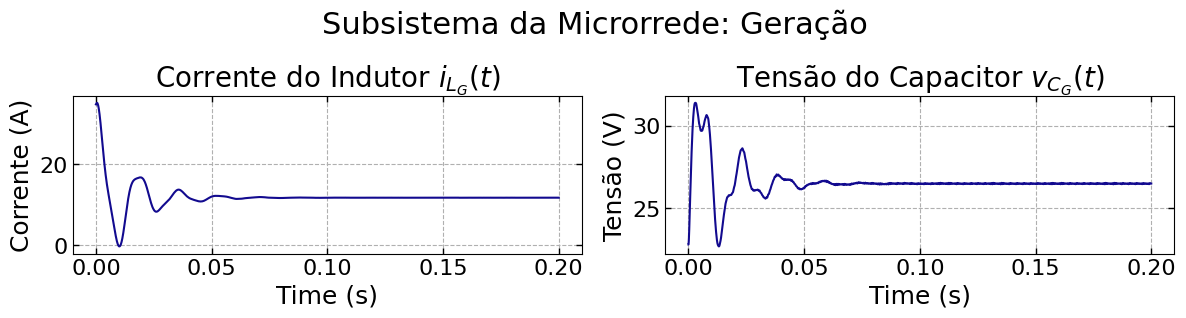

In [16]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3.2))

# Adicionando o título à figura
fig.suptitle("Subsistema da Microrrede: Geração", fontsize=22)

set_subplot(
    axs[0], t, y[0],
    'Time (s)', 'Corrente (A)', 'Corrente do Indutor $i_{L_G}(t)$',
)

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs[1],  t, y[3],
    'Time (s)', 'Tensão (V)', 'Tensão do Capacitor $v_{C_G}(t)$',
)

plt.tight_layout()

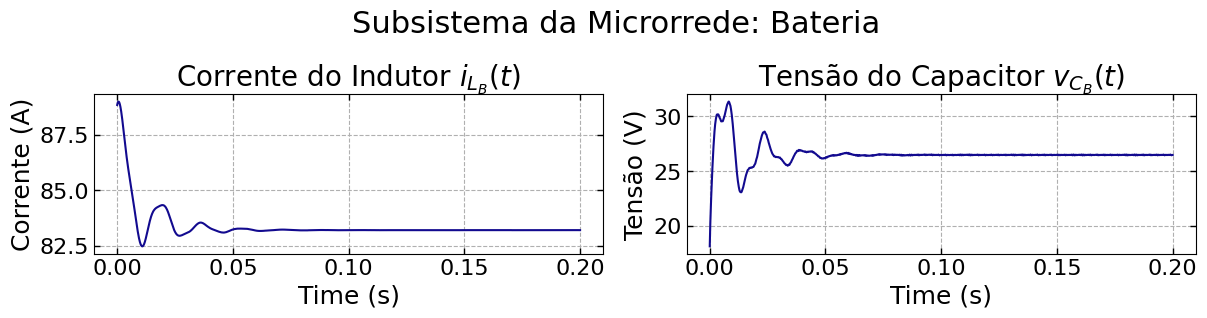

In [17]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3.2))

# Adicionando o título à figura
fig.suptitle("Subsistema da Microrrede: Bateria", fontsize=22)

set_subplot(
    axs[0], t, y[1],
    'Time (s)', 'Corrente (A)', 'Corrente do Indutor $i_{L_B}(t)$',
)

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs[1],  t, y[4],
    'Time (s)', 'Tensão (V)', 'Tensão do Capacitor $v_{C_B}(t)$',
)

plt.tight_layout()

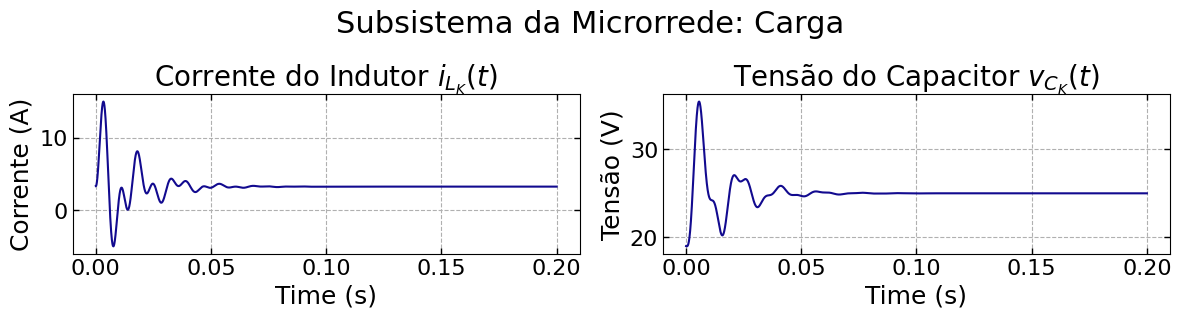

In [18]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3.2))

# Adicionando o título à figura
fig.suptitle("Subsistema da Microrrede: Carga", fontsize=22)

set_subplot(
    axs[0], t, y[2],
    'Time (s)', 'Corrente (A)', 'Corrente do Indutor $i_{L_K}(t)$',
)

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs[1],  t, y[5],
    'Time (s)', 'Tensão (V)', 'Tensão do Capacitor $v_{C_K}(t)$',
)

plt.tight_layout()

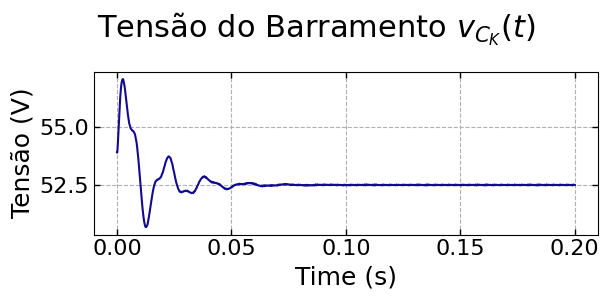

In [19]:
# Tensão do Barramento
VE = (REQ / R12) * y[1] + (REQ / R22) * y[3] - REQ * IB_O - REQ * y[4]

# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 1, figsize=(6, 3))

# Adicionando o título à figura
fig.suptitle("Tensão do Barramento $v_{C_K}(t)$", fontsize=22)

# set_subplot(
#     axs[0], t, y[2],
#     'Time (s)', 'Corrente (A)', 'Corrente do Indutor $i_{L_K}(t)$',
# )

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs,  t, VE,
    'Time (s)', 'Tensão (V)', '',
)

plt.tight_layout()